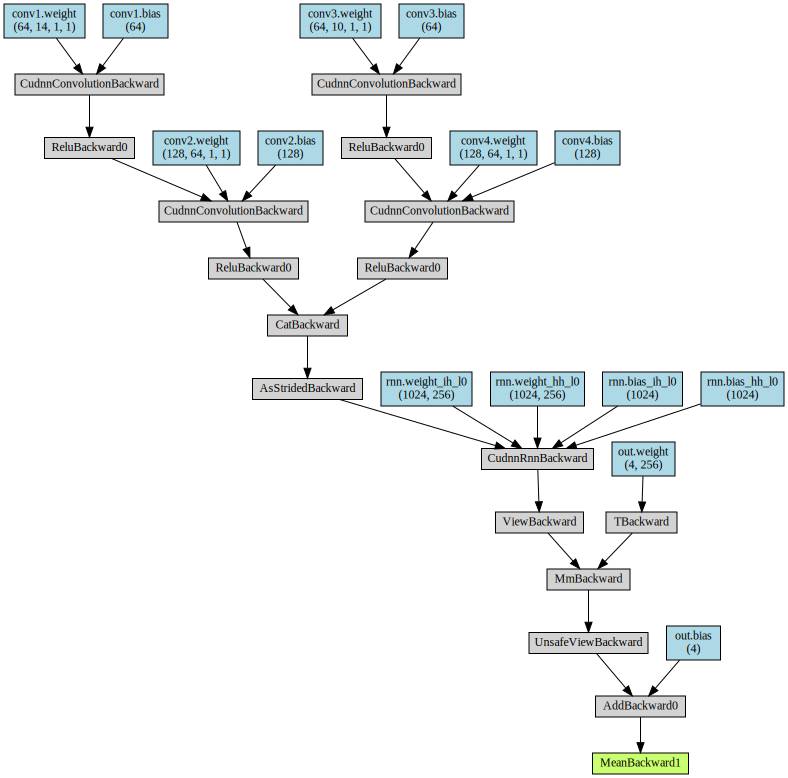

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchviz
import os
import numpy as np

# Hyper-Parameters
LAYER1_SIZE = 192
LEARNING_RATE = 0.001
INPUT_SIZE = 100
NUM_RNN_LAYER = 1
OUT_PUT_SIZE = 256


class ActorNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(ActorNet, self).__init__()
        self.out_put_size = OUT_PUT_SIZE
        self.conv1 = nn.Conv2d(in_channels=14, out_channels=64, kernel_size=1, stride=LAYER1_SIZE,)
        self.conv1.weight.data.normal_(0, 0.1)
        self.conv2 = nn.Conv2d(64, 128, 1, LAYER1_SIZE, )
        self.conv2.weight.data.normal_(0, 0.1)
        self.conv3 = nn.Conv2d(10, 64, 1, LAYER1_SIZE, )
        self.conv3.weight.data.normal_(0, 0.1)
        self.conv4 = nn.Conv2d(64, 128, 1, LAYER1_SIZE, )
        self.conv4.weight.data.normal_(0, 0.1)
        self.rnn = nn.LSTM(input_size=256,
                           hidden_size=OUT_PUT_SIZE,
                           num_layers=NUM_RNN_LAYER,
                           batch_first=True)
        self.out = nn.Linear(OUT_PUT_SIZE, action_dim)
        self.last_epi = -1

    def forward(self, state_agent, state_rider, hidden_cm):
        x = self.conv1(state_agent)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        y = self.conv3(state_rider)
        y = F.relu(y)
        y = self.conv4(y)
        y = F.relu(y)
        x = torch.cat((x.float(), y.float()), dim=1)
        x = x.reshape(-1, 1, 256)
        x, hidden_cm = self.rnn(x, hidden_cm)
        actions_value = self.out(x)
        return actions_value, hidden_cm


def state_initializer(shape, mode='g'):
    if mode == 'z':  # Zero
        initial = np.zeros(shape=shape)
    elif mode == 'g':  # Gaussian
        initial = np.random.normal(loc=0., scale=1./float(shape[1]), size=shape)
    else:  # May do some adaptive initializer can be built in later
        raise NotImplementedError
    return initial.astype(np.float32)

os.environ["PATH"] += os.pathsep + 'D:/graphviz-2.38/release/bin'
model = ActorNet(2, 4).cuda()
agent = torch.randn(32, 14, 1, 6).cuda()
rider = torch.randn(32, 10, 1, 6).cuda()
hidden_a = torch.from_numpy(state_initializer(shape=(NUM_RNN_LAYER, 32, OUT_PUT_SIZE), mode='z')).cuda()
actor_init_h_batch = (hidden_a, hidden_a)
score, (hidden_a, hidden_m) = model(agent, rider, actor_init_h_batch)

torchviz.make_dot(score.mean(), params=dict(model.named_parameters()))


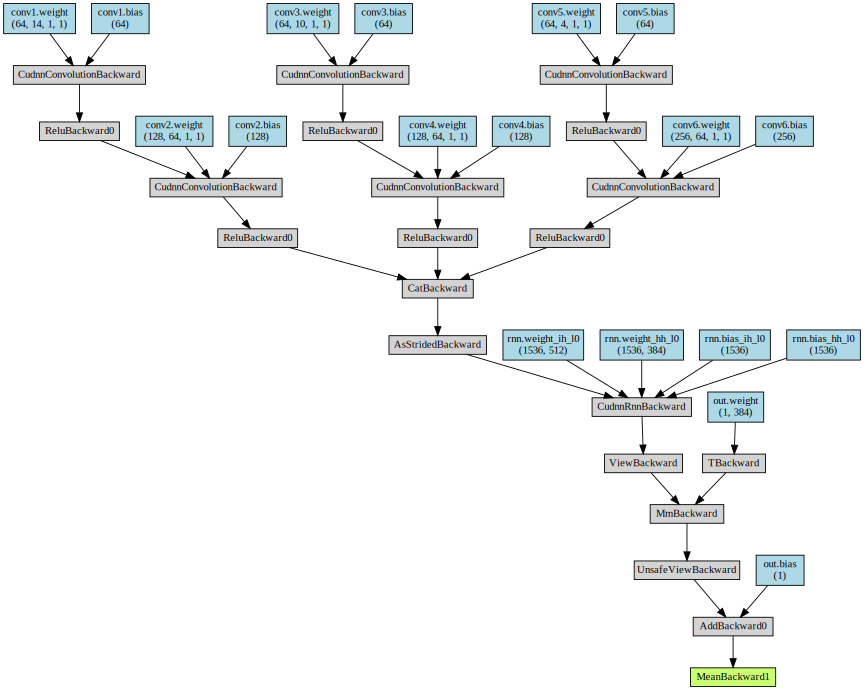

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchviz
import os

# Hyper-Parameters
LAYER1_SIZE = 192
LEARNING_RATE = 0.001
NUM_RNN_LAYER = 1
OUT_PUT_SIZE = 384


class CriticNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(CriticNet, self).__init__()
        self.out_put_size = OUT_PUT_SIZE
        self.conv1 = nn.Conv2d(in_channels=14, out_channels=64, kernel_size=1, stride=1, padding=0)
        self.conv1.weight.data.normal_(0, 0.1)
        self.conv2 = nn.Conv2d(64, 128, 1, 1, )
        self.conv2.weight.data.normal_(0, 0.1)

        self.conv3 = nn.Conv2d(10, 64, 1, 1, )
        self.conv3.weight.data.normal_(0, 0.1)
        self.conv4 = nn.Conv2d(64, 128, 1, 1, )
        self.conv4.weight.data.normal_(0, 0.1)

        self.conv5 = nn.Conv2d(action_dim, 64, 1, 1, )
        self.conv5.weight.data.normal_(0, 0.1)
        self.conv6 = nn.Conv2d(64, 256, 1, 1, )
        self.conv6.weight.data.normal_(0, 0.1)

        self.rnn = nn.LSTM(input_size=512,
                           hidden_size=OUT_PUT_SIZE,
                           num_layers=NUM_RNN_LAYER,
                           batch_first=True)
        self.out = nn.Linear(OUT_PUT_SIZE, 1)

    def forward(self, state_agent, state_rider, actor_out, hidden_cm):
        x = self.conv1(state_agent)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)

        y = self.conv3(state_rider)
        y = F.relu(y)
        y = self.conv4(y)
        y = F.relu(y)

        z = self.conv5(actor_out)
        z = F.relu(z)
        z = self.conv6(z)
        z = F.relu(z)

        x = torch.cat((x.float(), y.float(), z.float()), dim=1)
        x = x.reshape(-1, actor_out.shape[2], 512)
        x, hidden_cm = self.rnn(x, hidden_cm)
        actions_value = self.out(x)
        return actions_value, hidden_cm


def state_initializer(shape, mode='g'):
    if mode == 'z':  # Zero
        initial = np.zeros(shape=shape)
    elif mode == 'g':  # Gaussian
        initial = np.random.normal(loc=0., scale=1./float(shape[1]), size=shape)
    else:  # May do some adaptive initializer can be built in later
        raise NotImplementedError
    return initial.astype(np.float32)


os.environ["PATH"] += os.pathsep + 'D:/graphviz-2.38/release/bin'
model = CriticNet(2, 4).cuda()
agent = torch.randn(32, 14, 1, 6).cuda()
rider = torch.randn(32, 10, 1, 6).cuda()
action = torch.randn(32, 4, 1, 6).cuda()
hidden_a = torch.from_numpy(state_initializer(shape=(NUM_RNN_LAYER, 192, OUT_PUT_SIZE), mode='z')).cuda()
critic_init_h_batch = (hidden_a, hidden_a)
score, (hidden_a, hidden_m) = model(agent, rider, action, critic_init_h_batch)

torchviz.make_dot(score.mean(), params=dict(model.named_parameters()))
